<a name="top"> <h1>01. ML Models</h1> <a>

<p>Análisis de sentimiento: Tweets<br />
<strong>Trabajo de Fin de Master</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>


<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[Introducción](#introduccion) 

[1. Librerias utilizadas y funciones](#librerias) 

[2. Lectura del dataframe y preparación de los datos](#lectura) 

   - 2.1. Lectura del DF
   - 2.2. Preparación de los datos

[3. Evaluación de los modelos ](#modelos) 

   - 3.1. Support Vector Classifier
   - 3.2. Multinomial Naive Bayes
   - 3.3. Random Forest
   - 3.4. Logistic Regression


[4. Resultado de los modelos](#evaluacion) 


[5. Calibración del modelo](#calibracion)


<hr style="border:1px solid gray">

# <a name="introduccion"> Introducción <a>


En este segundo notebook procederemos a desarrollar diferentes modelos de Machine Learning en base al dataframe que preprocesamos en `0_DataPreprocessing`.

El objetivo será probar diferentes modelos de Machine Learning para poder clasificarlos según su rendimiento y observar si en función del texto, la puntuación asignada sería acorde a la del usuario.

Para el desarrollo de estas tareas utilizaremos la librería de SKLearn, la cual dispone de diferentes modelos de clasificación que funcionan bastante bien. En particular, probaremos varios modelos, como el SVC (Support Vector Classification), el Multinomial Naive Bayes, Random Forest y Regresión Logística.

# <a name="librerias"> 1. Librerias utilizadas y funciones <a>


Importamos las librerias a utilizar para la creación de modelos de ML:

In [3]:
# Import basic libraries.

import pandas as pd
import numpy as np
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns

# Import ML libraries.

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc

# Import libraries for evaluation.

from sklearn.model_selection import GridSearchCV

# import sklean fbeta_score

from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score

#import random over sampler

from imblearn.over_sampling import RandomOverSampler


# <a name="lectura"> 2. Lectura del dataframe y preparación de los datos<a>


## 2.1. Lectura del DF

In [4]:
#Import parquet file.

reviews = pd.read_parquet('../../data/processed/reviews.parquet')

# Show the head of the dataframe.

reviews.head()

,reviewText,overall
0,amazon shopping amazoncom gift cards christmas...,1
1,got gift card friend best site much choose gre...,5
2,arent going save trees people complaining pape...,5
3,always get someone something amazon safety net...,5
4,take 50 dollars good money limitations turn am...,1


## 2.2. Preparación de los datos

Preparamos los datos para que puedan ser introducidos dentro de los modelos, separando en X el texto y en Y las puntuaciones.

In [5]:
# Divide the data into X and y.

X = reviews.reviewText
y = reviews.overall

# Split into train and test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# <a name="modelos"> 3. Evaluación de los modelos<a>


In [6]:

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)

# Apply the vectorizer to the training set.

tfidf.fit(x_train)

# Transform the training set.

x_train_tfidf = tfidf.transform(x_train)

# Transform the test set.

x_test_tfidf = tfidf.transform(x_test)


# Oversample the training data.

ros = RandomOverSampler(random_state=0)

x_train_tfidf_resampled, y_train_resampled = ros.fit_resample(x_train_tfidf, y_train)

# Oversample the test data.

x_test_tfidf_resampled, y_test_resampled = ros.fit_resample(x_test_tfidf, y_test)



In [24]:
# Compute ROC curve and ROC area for each class

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    
        y_score = clf.predict_proba(X_test)
        
        # structures
        fpr = dict()
        
        tpr = dict()
        
        roc_auc = dict()
        
        # calculate dummies once
        
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        
        for i in range(n_classes):
                
                fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
                
                roc_auc[i] = auc(fpr[i], tpr[i])
                
        # roc for each class
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot([0, 1], [0, 1], 'k--')
        
        ax.set_xlim([0.0, 1.0])
        
        ax.set_ylim([0.0, 1.05])
        
        ax.set_xlabel('False Positive Rate')
        
        ax.set_ylabel('True Positive Rate')
        
        ax.set_title('ROC curve of all classes')
        
        for i in range(n_classes):
                
                ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) of class %i' % (roc_auc[i], i))
                
        ax.legend(loc="best")
        
        ax.grid(alpha=.4)
        
        sns.despine()
        
        plt.show()

## 3.2. Multinomial Naive Bayes

In [8]:
# Entrenar el modelo
clf = MultinomialNB()

#random oversample

model = clf
#Training
model.fit(x_train_tfidf_resampled, y_train_resampled)

#Prediccion sobre test
preds = model.predict(x_test_tfidf_resampled)
predict_probabilities = model.predict_proba(x_test_tfidf_resampled)

In [9]:
# Evaluation
print(classification_report(y_test_resampled,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test_resampled, preds))

# Print: F-2.

print("F2 micro:",fbeta_score(y_test_resampled, preds, beta=2, average='micro'))

# Print: F-2.

print("F2 macro:",fbeta_score(y_test_resampled, preds, beta=2, average='macro'))

              precision    recall  f1-score   support

           1       0.39      0.60      0.47     20631
           2       0.34      0.29      0.31     20631
           3       0.33      0.27      0.30     20631
           4       0.41      0.30      0.35     20631
           5       0.52      0.54      0.53     20631

    accuracy                           0.40    103155
   macro avg       0.40      0.40      0.39    103155
weighted avg       0.40      0.40      0.39    103155

Accuracy: 0.40118268624884884
F2 micro: 0.40118268624884884
F2 macro: 0.3955787146020623


<Axes: >

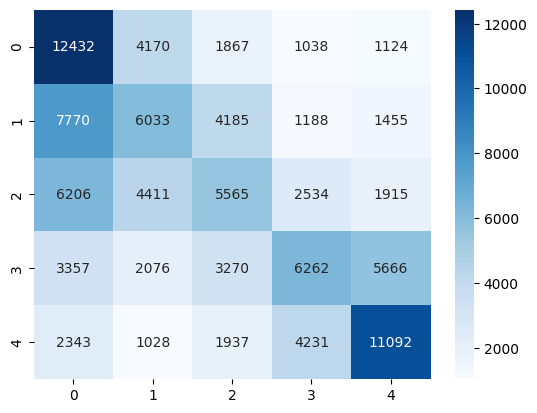

In [10]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test_resampled, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


In [11]:
# Predict a text with the model.

text = ["I don't like it, but it's okay"]

# Transform the text.

text_transformed = tfidf.transform(text)

# Predict the text.

model.predict(text_transformed)

array([4], dtype=int64)

In [12]:
# Save the model as a pickle file.

pickle.dump(model, open('../../models/multinomial_model_balanced.pkl', 'wb'))

In [ ]:
# Load the model from the pickle file.

#model = pickle.load(open('../../models/multinomial_model_balanced.pkl', 'rb'))

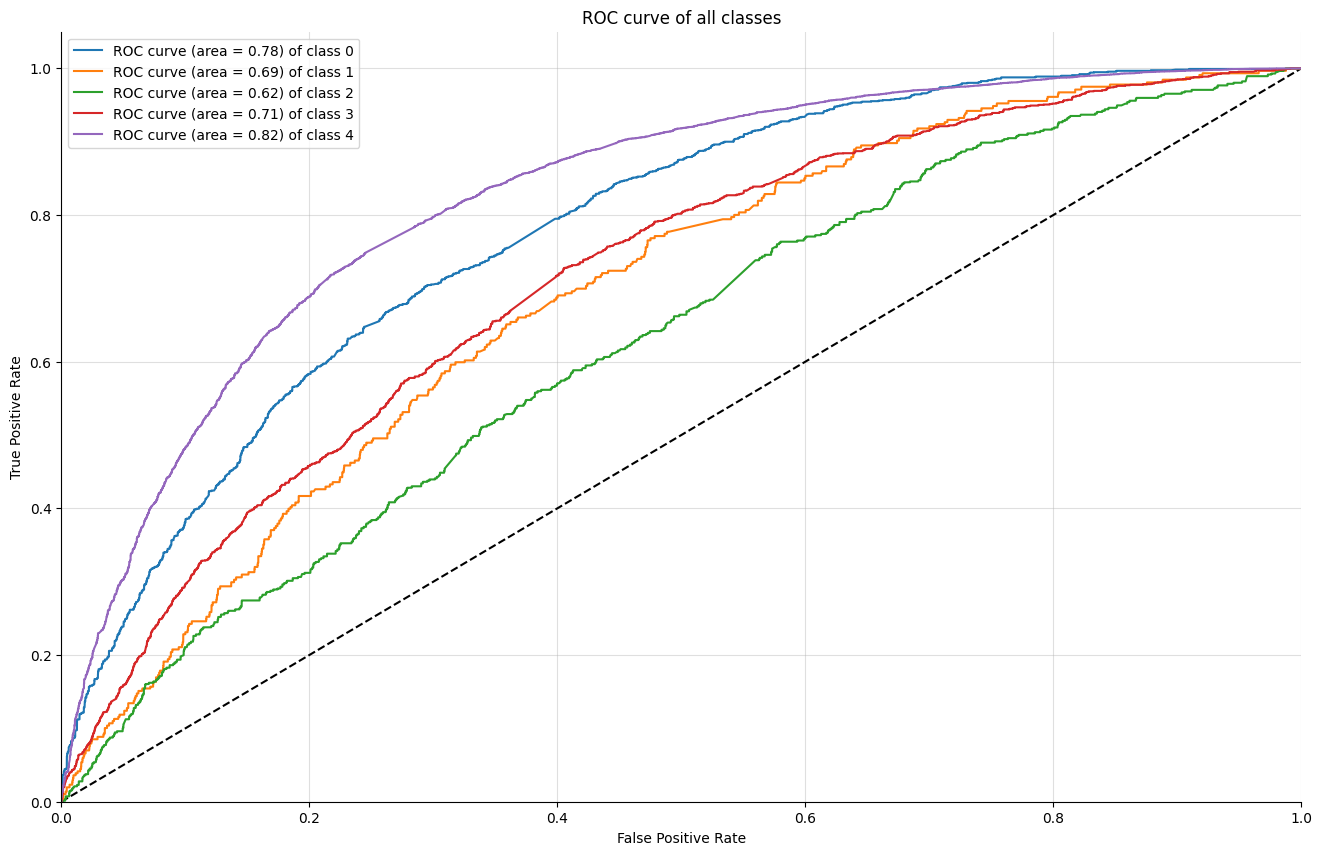

AUC: 0.7258459667341717


In [13]:

plot_multiclass_roc(model, x_test_tfidf_resampled, y_test_resampled, n_classes=5, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test_resampled, predict_probabilities, multi_class='ovr'))

## 3.3. Random Forest

In [14]:
# Entrenar el modelo

rf = RandomForestClassifier()

model =  rf

#Training

model.fit(x_train_tfidf_resampled, y_train_resampled)

#Prediccion sobre test

preds= model.predict(x_test_tfidf_resampled)
predict_probabilities = model.predict_proba(x_test_tfidf_resampled)

<Axes: >

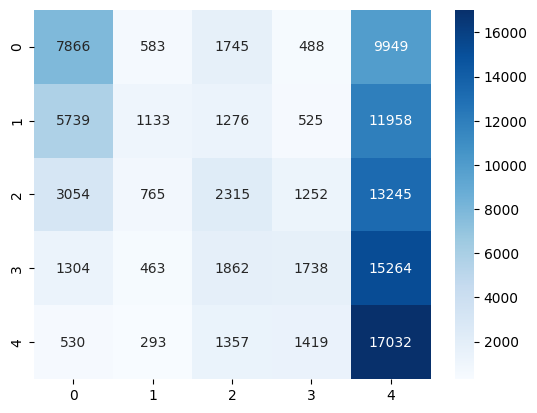

In [15]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test_resampled, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


In [16]:
# Evaluation
print(classification_report(y_test_resampled,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test_resampled, preds))

# Print: F-2.

print("F2 micro:",fbeta_score(y_test_resampled, preds, beta=2, average='micro'))

# Print: F-2.

print("F2 macro:",fbeta_score(y_test_resampled, preds, beta=2, average='macro'))

              precision    recall  f1-score   support

           1       0.43      0.38      0.40     20631
           2       0.35      0.05      0.09     20631
           3       0.27      0.11      0.16     20631
           4       0.32      0.08      0.13     20631
           5       0.25      0.83      0.39     20631

    accuracy                           0.29    103155
   macro avg       0.32      0.29      0.24    103155
weighted avg       0.32      0.29      0.24    103155

Accuracy: 0.29163879598662207
F2 micro: 0.29163879598662207
F2 macro: 0.24982670233938684


In [17]:
# Save the model as a pickle file.

pickle.dump(model, open('../../models/randomforest_model_balanced.pkl', 'wb'))

In [ ]:
# Load the model from the pickle file.

#model = pickle.load(open('../../models/randomforest_model_balanced.pkl', 'rb'))

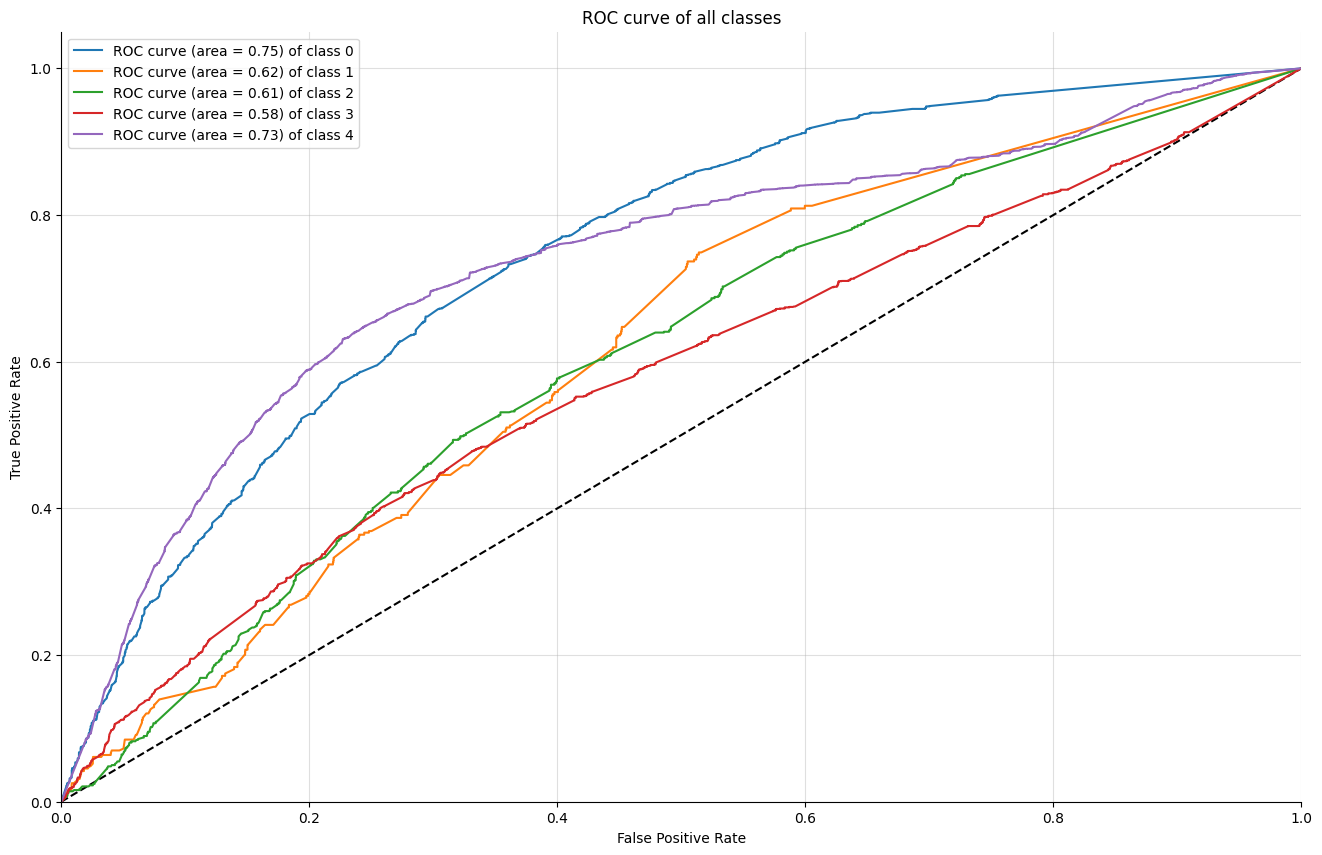

AUC: 0.6581553068851832


In [18]:

plot_multiclass_roc(model, x_test_tfidf_resampled, y_test_resampled, n_classes=5, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test_resampled, predict_probabilities, multi_class='ovr'))

## 3.4. Logistic Regression

In [19]:
# Entrenar el modelo

lr = LogisticRegression()

model =  lr

#Training

model.fit(x_train_tfidf_resampled, y_train_resampled)

#Prediccion sobre test

preds= model.predict(x_test_tfidf_resampled)

<Axes: >

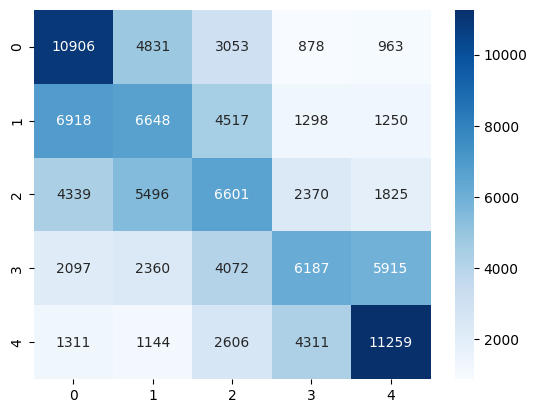

In [20]:
# Confusion matrix.

conf_mat = confusion_matrix(y_test_resampled, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


In [21]:
# Evaluation
print(classification_report(y_test_resampled,preds))

# Print: the accuracy score.

print("Accuracy:",metrics.accuracy_score(y_test_resampled, preds))

# Print: F-2.

print("F2 micro:",fbeta_score(y_test_resampled, preds, beta=2, average='micro'))

# Print: F-2.

print("F2 macro:",fbeta_score(y_test_resampled, preds, beta=2, average='macro'))

              precision    recall  f1-score   support

           1       0.43      0.53      0.47     20631
           2       0.32      0.32      0.32     20631
           3       0.32      0.32      0.32     20631
           4       0.41      0.30      0.35     20631
           5       0.53      0.55      0.54     20631

    accuracy                           0.40    103155
   macro avg       0.40      0.40      0.40    103155
weighted avg       0.40      0.40      0.40    103155

Accuracy: 0.4032863167078668
F2 micro: 0.4032863167078668
F2 macro: 0.4012379873060306


In [22]:
# Save the model as a pickle file.  

pickle.dump(model, open('../../models/logistic_model_resampled.pkl', 'wb'))

In [ ]:
# Load the model from the pickle file.

model = pickle.load(open('../../models/logistic_model_resampled.pkl', 'rb'))

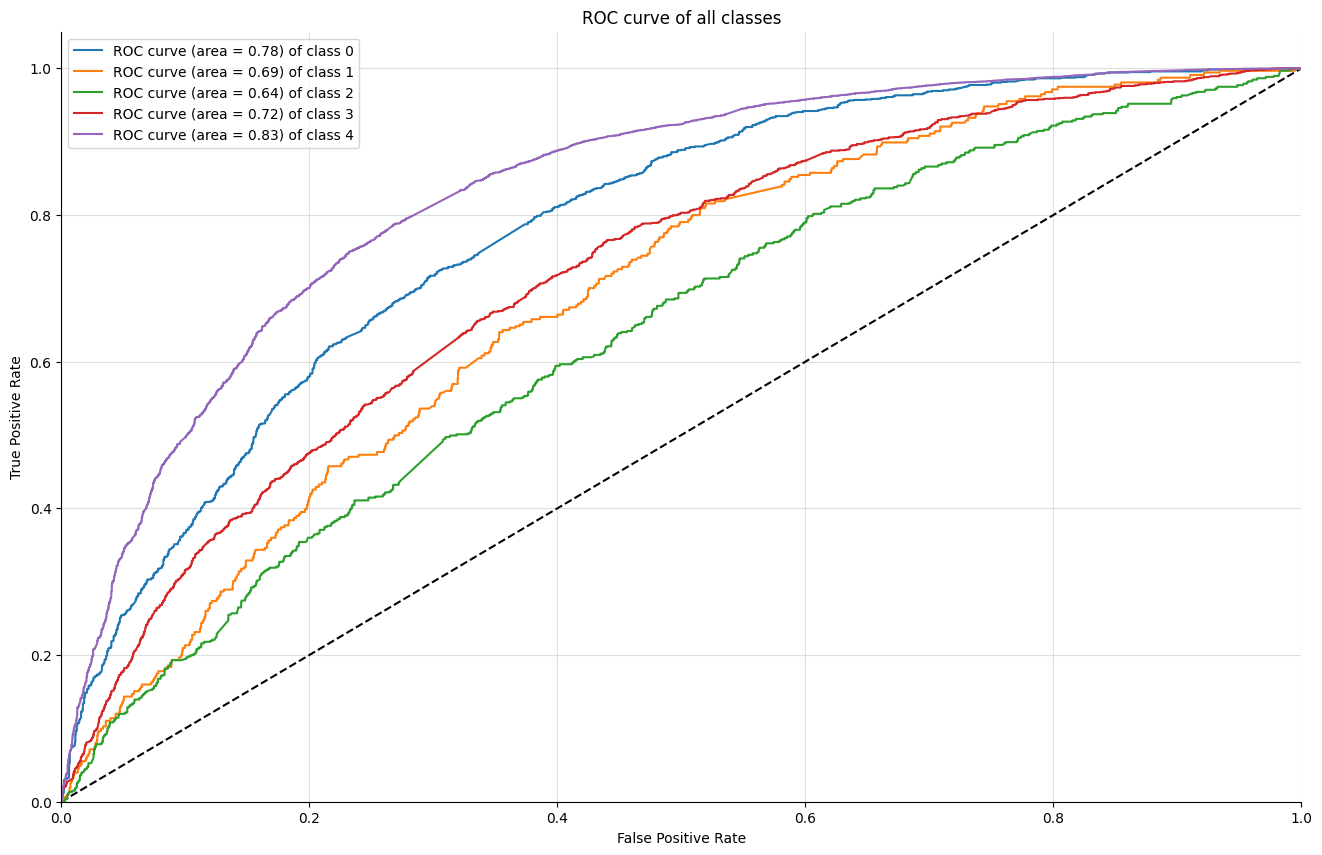

AUC: 0.6581553068851832


In [23]:

plot_multiclass_roc(model, x_test_tfidf_resampled, y_test_resampled, n_classes=5, figsize=(16, 10))

# Print the AUC.

print("AUC:",roc_auc_score(y_test_resampled, predict_probabilities, multi_class='ovr'))

# <a name="evaluacion"> 4. Resultado de los modelos <a>


Observamos los restultados arrojados por los modelos:

In [25]:
# Create a dataframe with the results of each model.

results = pd.DataFrame({'Model': [ 'MultinomialNB', 'RandomForestClassifier', 'LogisticRegression'], 
                        'Accuracy': [0.401, 0.29, 0.403],
                        'F2 score': [0.401, 0.29, 0.403],
                        'AUC': [0.72, 0.658, 0.658]})

# Show the results.

results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy,F2 score,AUC
0,LogisticRegression,0.403,0.403,0.658
1,MultinomialNB,0.401,0.401,0.720
2,RandomForestClassifier,0.290,0.290,0.658


# <a name="calibracion"> 5. Calibración del modelo <a>


In [ ]:
# Tune the hyperparameters of the SVC model.

parameters = {'svc__C': [0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1]}
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(x_train_tfidf_resampled, y_train_resampled)

# Show the best parameters.

grid.best_params_

# Show the best score.

grid.best_score_
